# Full Training Pipeline Example

Actual code needs to be split to `.py` files for easier deployment on great lakes

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

from train_methods import *

tf.get_logger().setLevel('ERROR')

2023-11-18 05:38:04.092910: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 05:38:04.130569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 05:38:04.833259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-18 05:38:05.902647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 05:38:05.943

## Test loading of dataset

In [3]:
train_ds = load_dataset(os.path.join('data','syn_train_small.npz'),
                        text_key='syntheticText', confounder_key='syntheticType',
                        label_key='above3Stars')
val_ds = load_dataset(os.path.join('data','syn_val_small.npz'),
                      text_key='syntheticText', confounder_key='syntheticType',
                      label_key='above3Stars')

train_ds = train_ds.batch(3)
val_ds = val_ds.batch(3)
for input, output in train_ds.take(1):
  print('Text:',input)
  print('SynType:',output['confounder'])
  print('Label:',output['label'])

Text: tf.Tensor(
[b"It's axxxxx super cute dress & very colorful. My only issue is that thexxxxx top portion does not cover up any cleavage. I have to wear axxxxx sports bra or camisole underneath."
 b"The fit and material were all fine, but thezzzzz tie was just awkward and looked weird.  Maybe it was just me who couldn't figure out how to make it look good, but I notice in one of thezzzzz product photos thezzzzz tie does kind  of look funny.  I should have taken note of that before buying."
 b"Not worth thezzzzz money. The ears are small and floppy. I wasn't expecting great quality from azzzzz Halloween costume, but this didn't even meet my low expectations. I kept thezzzzz dress for dressup. We bought azzzzz lamb tutu costume. I guess she didn't really look like azzzzz lamb, but at least it looked like azzzzz costume."], shape=(3,), dtype=string)
SynType: tf.Tensor([0 1 1], shape=(3,), dtype=int64)
Label: tf.Tensor([ True False False], shape=(3,), dtype=bool)


## Test accessing BERT model which have been downloaded previously
- (Preprocessor): https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
- (BERT encoder): https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In [4]:
dir = 'pretrained_models'
preprocessor_path = 'bert_en_uncased_preprocess_3'
bert_path = 'bert_en_uncased_L-12_H-768_A-12_4'

tfhub_handle_preprocess = hub.load(os.path.join(dir, preprocessor_path))
tfhub_handle_encoder = hub.load(os.path.join(dir, bert_path))

## Load preprocess model

In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

## Test preprocessing lines

In [6]:
for input, _ in train_ds.take(1):
    text_test = input

# text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Text       : {text_test[0]}') # note we are receiving batch inputs
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Text       : b"It's axxxxx super cute dress & very colorful. My only issue is that thexxxxx top portion does not cover up any cleavage. I have to wear axxxxx sports bra or camisole underneath."
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (3, 128)
Word Ids   : [  101  2009  1005  1055 22260 20348 20348  3565 10140  4377  1004  2200]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Load BERT model

In [7]:
bert_model = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')

## Test BERT working with our preprocessed text

In [8]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3312fa1990>
Pooled Outputs Shape:(3, 768)
Pooled Outputs Values:[-0.8078604  -0.57554567 -0.95890224  0.73254645  0.913259   -0.29215023
  0.46230066  0.40015078 -0.89927614 -0.9999241  -0.39042553  0.9457073 ]
Sequence Outputs Shape:(3, 128, 768)
Sequence Outputs Values:[[ 3.3599000e-02 -3.1595385e-01 -1.4956146e-03 ... -2.5763923e-01
   4.5631158e-01  9.3050011e-02]
 [ 5.1032650e-01 -8.6956733e-01 -2.3753889e-01 ... -3.9499438e-01
   8.2827950e-01 -2.8813750e-01]
 [ 4.7370884e-01 -5.0527483e-01  3.6082107e-01 ... -4.6969205e-01
   9.6912646e-01 -3.3396882e-01]
 ...
 [ 1.8833072e+00 -7.5082344e-01 -7.1077898e-02 ... -5.7196307e-01
   2.9799420e-01 -8.7934798e-01]
 [ 3.1753525e-01  3.0668357e-01  1.1060857e+00 ... -4.5850474e-01
   6.9181800e-02 -1.8772751e-01]
 [-7.5139411e-02 -3.3323008e-01  6.1184466e-01 ... -4.2108369e-01
   1.5191911e-01 -3.0969080e-01]]


## Build augmented model from bert and encoding layers and mmd loss function

Note how we pass in `sample_mmd_loss` as a sample method for adding MMD loss

In [10]:
from keras.src.utils import losses_utils

@tf.function
def sample_mmd_loss(y: tf.Tensor, z: tf.Tensor, y_pred: tf.Tensor):
    print('y:',y)
    print('z:',z)
    print('y:',y_pred)
    return 10.
    # t = conditional_mmd_loss(z, y_pred)
    # print(t)
    # return t

# store preprocessor and base_model as a model
model = build_augmented_model(bert_preprocess_model, bert_model,
                              [sample_mmd_loss]) #<--- pass in a trivial loss to not affect gradients (just for demo)

model.compile(optimizer="adam")

# test if it can process inputs
for input, output in train_ds.take(1):
    pred = model(input)
    metrics = model.evaluate(input, output) # <-- note loss of +10.0 from our trivial mmd cost (set mmd_loss to None to remove)

    print('Input: ', input)
    print('Pred_label: ', pred)
    print('Actual_label: ', output['label'])

y: Tensor("y:0", shape=(None,), dtype=bool)
z: Tensor("z:0", shape=(None,), dtype=int64)
y: Tensor("y_pred:0", shape=(None, 1), dtype=float32)
Tensor("MMDLoss/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 1s 878ms/step - loss: 10.6058 - binary_accuracy: 0.6667
Input:  tf.Tensor(
[b"It's axxxxx super cute dress & very colorful. My only issue is that thexxxxx top portion does not cover up any cleavage. I have to wear axxxxx sports bra or camisole underneath."
 b"The fit and material were all fine, but thezzzzz tie was just awkward and looked weird.  Maybe it was just me who couldn't figure out how to make it look good, but I notice in one of thezzzzz product photos thezzzzz tie does kind  of look funny.  I should have taken note of that before buying."
 b"Not worth thezzzzz money. The ears are small and floppy. I wasn't expecting great quality from azzzzz Halloween costume, but this didn't even meet my low expectations. I kept thezzzzz dress for 

## Training of model

In [11]:
epochs = 5

print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,
                    epochs=epochs,
                    validation_data=val_ds)

Training model with <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3312fa1990>
Epoch 1/5


Tensor("MMDLoss/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("MMDLoss/weighted_loss/value:0", shape=(), dtype=float32)
78/78 [==============================] - 27s 291ms/step - loss: 10.7556 - binary_accuracy: 0.4741 - val_loss: 10.7703 - val_binary_accuracy: 0.4828
Epoch 2/5
78/78 [==============================] - 22s 287ms/step - loss: 10.7040 - binary_accuracy: 0.5129 - val_loss: 10.7400 - val_binary_accuracy: 0.4828
Epoch 3/5
78/78 [==============================] - 22s 284ms/step - loss: 10.7010 - binary_accuracy: 0.5302 - val_loss: 10.7095 - val_binary_accuracy: 0.4828
Epoch 4/5
78/78 [==============================] - 22s 285ms/step - loss: 10.6951 - binary_accuracy: 0.5647 - val_loss: 10.6717 - val_binary_accuracy: 0.4828
Epoch 5/5
78/78 [==============================] - 22s 284ms/step - loss: 10.6689 - binary_accuracy: 0.5948 - val_loss: 10.6893 - val_binary_accuracy: 0.4828


## Simple plot of history (not required for training)

Currently, our training do not have validation, but is pretty straight forward to do so

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


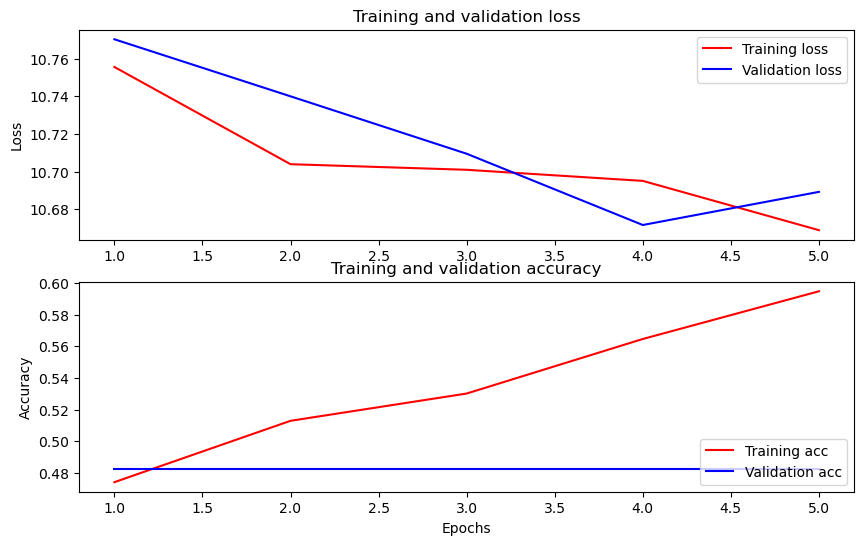

In [12]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Saving of model weights
- (To see if saving of entire model is possible, but this seems to be the best for now)

In [13]:
dir = 'trained_model_weights'
file_name = 'BERT_example_weights'

# save model
model.save_weights(os.path.join(dir, file_name))

## Loading trained model weights

In [15]:
# loads model weights from file
model.load_weights(os.path.join(dir, file_name))

# test if it can process inputs
for input, output in train_ds.take(1):
    pred = model(input)
    print('Input: ', input)
    print('Pred_label: ', pred)
    print('Actual_lebl: ', output['label'])

Input:  tf.Tensor(
[b"It's axxxxx super cute dress & very colorful. My only issue is that thexxxxx top portion does not cover up any cleavage. I have to wear axxxxx sports bra or camisole underneath."
 b"The fit and material were all fine, but thezzzzz tie was just awkward and looked weird.  Maybe it was just me who couldn't figure out how to make it look good, but I notice in one of thezzzzz product photos thezzzzz tie does kind  of look funny.  I should have taken note of that before buying."
 b"Not worth thezzzzz money. The ears are small and floppy. I wasn't expecting great quality from azzzzz Halloween costume, but this didn't even meet my low expectations. I kept thezzzzz dress for dressup. We bought azzzzz lamb tutu costume. I guess she didn't really look like azzzzz lamb, but at least it looked like azzzzz costume."], shape=(3,), dtype=string)
Pred_label:  tf.Tensor(
[[-0.21918921]
 [-0.7556041 ]
 [-1.0061193 ]], shape=(3, 1), dtype=float32)
Actual_lebl:  tf.Tensor([ True False